# Курсовой проект

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
DATASET_TRAIN_PATH = 'train.csv'
DATASET_TEST_PATH = 'test.csv'

## Загрузка данных

In [4]:
df = pd.read_csv(DATASET_TRAIN_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,nan,0,11,B,184966.93073
1,15053,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006
2,4765,53,2.00000,44.94795,29.19761,0.00000,8,12.00000,1968,0.04964,B,B,34,7759,0,229.00000,1,3,B,220925.90852
3,5809,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722
4,10783,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164


In [5]:
df_test = pd.read_csv(DATASET_TEST_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.00000,49.88264,33.43278,6.00000,6,14.00000,1972,0.31020,B,B,11,2748,1,nan,0,0,B
1,15856,74,2.00000,69.26318,nan,1.00000,6,1.00000,1977,0.07578,B,B,6,1437,3,nan,0,2,B
2,5480,190,1.00000,13.59782,15.94825,12.00000,2,5.00000,1909,0.00000,B,B,30,7538,87,4702.00000,5,5,B
3,15664,47,2.00000,73.04661,51.94084,9.00000,22,22.00000,2007,0.10187,B,B,23,4583,3,nan,3,3,B
4,14275,27,1.00000,47.52711,43.38757,1.00000,17,17.00000,2017,0.07216,B,B,2,629,1,nan,0,0,A


In [6]:
final = pd.DataFrame()
final['Id'] = df_test['Id']

#### Описание датасета
- Id - идентификационный номер квартиры

- DistrictId - идентификационный номер района

- Rooms - количество комнат

- Square - площадь

- LifeSquare - жилая площадь

- KitchenSquare - площадь кухни

- Floor - этаж

- HouseFloor - количество этажей в доме

- HouseYear - год постройки дома

- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

- Social_1, Social_2, Social_3 - социальные показатели местности

- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

- Price - цена квартиры

## Предобработка данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.00000,8383.40770,4859.01902,0.00000,4169.50000,8394.50000,12592.50000,16798.00000
DistrictId,10000.00000,50.40080,43.58759,0.00000,20.00000,36.00000,75.00000,209.00000
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Square,10000.00000,56.31578,21.05873,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19964,86.24121,0.37062,22.76983,32.78126,45.12880,7480.59213
KitchenSquare,10000.00000,6.27330,28.56092,0.00000,1.00000,6.00000,9.00000,2014.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000
HouseYear,10000.00000,3990.16630,200500.26143,1910.00000,1974.00000,1977.00000,2001.00000,20052011.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187


Преобразуем DistrictId, т.к. это категориальный признак

In [9]:
df['DistrictId'] = df['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

Преобразуем целочисленные признаки из float в int:

In [10]:
int_colnames = [
    'Rooms', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1'
]

for colname in int_colnames:
    df[colname] = df[colname].astype('int32')
    df_test[colname] = df_test[colname].astype('int32')

df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.98156,29.44275,6.00000,7,9,1969,0.08904,B,B,33,7976,5,nan,0,11,B,184966.93073
1,15053,41,3,65.68364,40.04954,8.00000,7,9,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006
2,4765,53,2,44.94795,29.19761,0.00000,8,12,1968,0.04964,B,B,34,7759,0,229.00000,1,3,B,220925.90852
3,5809,58,2,53.35298,52.73151,9.00000,8,17,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722
4,10783,99,1,39.64919,23.77617,7.00000,11,12,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164


Значения max и min не выходят за пределы int32 и float32, поэтому можно уменьшить разрядность данных

In [11]:
def reduce_data_type(dFrame):
    types = dFrame.dtypes

    float_idexes = list(types[types == 'float64'].index)
    other_indexes = list(types[(types != 'float64')].index)
    
    return pd.concat(
        [
            dFrame[float_idexes].astype('float32'),
            dFrame[other_indexes],
        ],
        axis=1
    )

df = reduce_data_type(df)

df_test = reduce_data_type(df_test)

df.head()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price,Id,DistrictId,Rooms,Floor,HouseFloor,HouseYear,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,47.98156,29.44275,6.00000,0.08904,nan,184966.93750,14038,35,2,7,9,1969,B,B,33,7976,5,0,11,B
1,65.68364,40.04954,8.00000,0.00007,240.00000,300009.43750,15053,41,3,7,9,1978,B,B,46,10309,1,1,16,B
2,44.94795,29.19761,0.00000,0.04964,229.00000,220925.90625,4765,53,2,8,12,1968,B,B,34,7759,0,1,3,B
3,53.35298,52.73151,9.00000,0.43789,1084.00000,175616.23438,5809,58,2,8,17,1977,B,B,23,5735,3,0,5,B
4,39.64919,23.77617,7.00000,0.01234,2078.00000,150226.53125,10783,99,1,11,12,1976,B,B,35,5776,1,2,4,B


### Обработка пропусков

In [12]:
null_info = df.isnull().sum()
null_info

Square              0
LifeSquare       2113
KitchenSquare       0
Ecology_1           0
Healthcare_1     4798
Price               0
Id                  0
DistrictId          0
Rooms               0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [13]:
null_info_test = df_test.isnull().sum()
null_info_test

Square              0
LifeSquare       1041
KitchenSquare       0
Ecology_1           0
Healthcare_1     2377
Id                  0
DistrictId          0
Rooms               0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

LifeSquare заполим позже вместе с выбросами других признаков площадей.
Из отсутствия Healthcare_1 построим отдельный признак

### Обработка выбросов

In [14]:
df_descr = df.describe()
df_descr_test = df_test.describe()

df_descr.T

,count,mean,std,min,25%,50%,75%,max
Square,10000.00000,56.31571,21.05872,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19960,86.24111,0.37062,22.76983,32.78126,45.12880,7480.59229
KitchenSquare,10000.00000,6.27330,28.56111,0.00000,1.00000,6.00000,9.00000,2014.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187
Healthcare_1,5202.00000,1142.90442,1021.51898,0.00000,350.00000,900.00000,1548.00000,4849.00000
Price,10000.00000,214139.21875,92872.30469,59174.77734,153872.62891,192269.64844,249135.46094,633233.43750
Id,10000.00000,8383.40770,4859.01902,0.00000,4169.50000,8394.50000,12592.50000,16798.00000
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000


**KitchenSquare, LifeSquare, Square**

In [15]:
square_features = ['KitchenSquare', 'LifeSquare', 'Square']

def plot_squares():
    square_features = ['KitchenSquare', 'LifeSquare', 'Square']
    for feature in square_features:
        plt.plot(df[[feature]])

    plt.legend(labels=square_features)
    plt.xlabel("Id")
    plt.ylabel("Square")

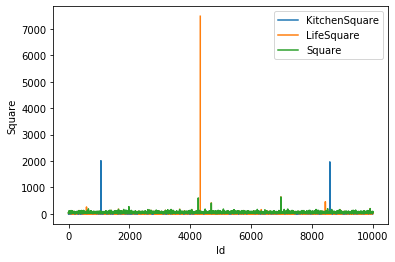

In [16]:
plot_squares()

In [17]:
def get_wrong_square_dict(dFrame):
    return {
       'KitchenSquare': (dFrame['KitchenSquare'] > 400) | (dFrame['KitchenSquare'] < 3),
       'LifeSquare': (dFrame['LifeSquare'] > 600) | (dFrame['LifeSquare'] > dFrame['Square']) | (dFrame['LifeSquare'] < 3),
       'Square': dFrame['Square'] < 10
    }

In [18]:
df_wrong_squares = get_wrong_square_dict(df)
df_test_wrong_squares = get_wrong_square_dict(df_test)

In [19]:
def fill_nan_wrong_square(dFrame):
    wrong_squares = get_wrong_square_dict(dFrame)
    for key, val in wrong_squares.items():
        dFrame.loc[val, key] = np.nan
    return dFrame

df = fill_nan_wrong_square(df)
df_test = fill_nan_wrong_square(df_test)

In [20]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

def predict_wrong_squares(dFrame):
    imputer = IterativeImputer(max_iter=100)
    imp = pd.DataFrame(imputer.fit_transform(dFrame.select_dtypes(exclude=['object', 'int32'])))
    imp.columns = dFrame.select_dtypes(exclude=['object', 'int32']).columns
    dFrame[square_features] = imp[square_features]
    return dFrame

df = predict_wrong_squares(df)
df_test = predict_wrong_squares(df_test)

In [21]:
square_diff_wrong = df['Square'] < df['LifeSquare'] + df['KitchenSquare']
square_diff_wrong_test = df_test['Square'] < df_test['LifeSquare'] + df_test['KitchenSquare']

df[square_diff_wrong]

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price,Id,DistrictId,Rooms,Floor,HouseFloor,HouseYear,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
3,53.35298,52.73151,9.00000,0.43789,1084.00000,175616.23438,5809,58,2,8,17,1977,B,B,23,5735,3,0,5,B
14,53.76910,52.40803,5.86875,0.07216,nan,140647.56250,10953,27,1,5,4,1977,B,B,2,629,1,0,0,A
42,56.49432,54.72357,5.86912,0.00712,nan,196078.90625,9833,1,2,9,17,1977,B,B,1,264,0,0,1,B
48,47.08010,46.80799,12.00000,0.01407,nan,96029.16406,7596,23,1,3,9,1977,B,B,2,475,0,0,0,B
69,64.92910,63.30460,10.00000,0.07216,nan,228584.00000,6925,27,2,15,17,2016,B,B,2,629,1,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,39.21141,36.15943,5.81412,0.04964,229.00000,180600.18750,3355,53,1,19,18,2019,B,B,34,7759,0,1,3,B
9951,33.51631,31.08624,5.17970,0.06975,nan,148066.43750,9237,25,1,13,11,2015,B,B,53,13670,4,1,11,B
9964,49.57459,45.59057,6.04184,0.07216,nan,145025.09375,10463,27,3,18,25,2013,B,B,2,629,1,0,0,A
9974,33.22709,32.63917,5.07257,0.00008,1046.00000,65949.31250,2159,30,1,4,4,2016,B,B,22,6398,141,3,23,B


In [22]:
df.loc[square_diff_wrong, 'Square'] = df.loc[square_diff_wrong, 'LifeSquare'] + df.loc[square_diff_wrong, 'KitchenSquare']
df_test.loc[square_diff_wrong_test, 'Square'] = \
    df_test.loc[square_diff_wrong_test, 'LifeSquare'] + \
    df_test.loc[square_diff_wrong_test, 'KitchenSquare']

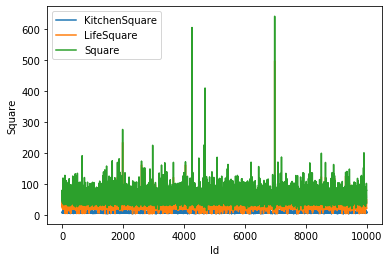

In [23]:
plot_squares()

**Rooms**

In [24]:
df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [25]:
rooms_wrong = (df['Rooms'] < 1) | (df['Rooms'] > 18)
rooms_wrong_test = (df_test['Rooms'] < 1) | (df_test['Rooms'] > 18)

df[rooms_wrong]

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price,Id,DistrictId,Rooms,Floor,HouseFloor,HouseYear,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
1397,145.19542,136.21550,8.97992,0.07542,nan,268394.75000,12638,27,0,4,3,2016,B,B,11,3097,0,0,0,B
1454,42.00605,21.77929,7.00000,0.00712,nan,78364.61719,8491,1,19,17,17,2014,B,B,1,264,0,0,1,B
1981,222.95987,211.23112,11.72875,0.21140,nan,302211.25000,7917,27,0,2,3,2008,B,B,9,1892,0,0,1,B
2269,41.79088,26.88866,7.31932,0.21140,nan,98129.97656,7317,27,0,13,0,1977,B,B,9,1892,0,0,1,B
3911,49.48350,30.82830,7.74643,0.11854,1183.00000,217009.34375,770,28,0,16,0,2015,B,B,30,6207,1,1,0,B
4366,81.49145,54.77574,10.30495,0.24320,540.00000,212864.79688,456,6,0,4,0,1977,B,B,5,1564,0,0,0,B
4853,49.24107,32.01731,7.83274,0.01765,nan,126596.94531,3224,27,0,1,0,1977,B,B,2,469,0,0,0,B
6149,38.69712,19.34513,9.00000,0.12738,nan,158998.10938,3159,88,0,9,16,1982,B,B,43,8429,3,3,9,B
8834,92.27198,85.12547,7.14651,0.21140,nan,219281.92188,9443,27,0,5,15,1977,B,B,9,1892,0,0,1,B


In [26]:
one_room_square = df_descr['LifeSquare']['mean'] / df_descr['Rooms']['mean']
one_room_square

19.677120552779314

In [27]:
df.loc[rooms_wrong, 'Rooms'] = (df.loc[rooms_wrong, 'LifeSquare'] / one_room_square).astype('int32')
df_test.loc[rooms_wrong_test, 'Rooms'] = (df_test.loc[rooms_wrong_test, 'LifeSquare'] / one_room_square).astype('int32')

**HouseYear**

In [28]:
houseYear = df['HouseYear'].value_counts().index
print(f'min = {houseYear.min()}, max = {houseYear.max()}')

min = 1910, max = 20052011


In [29]:
df.loc[(df['HouseYear'] > 2020), 'HouseYear'] = df['HouseYear'].mode()[0]
df_test.loc[(df_test['HouseYear'] > 2020), 'HouseYear'] = df['HouseYear'].mode()[0]

**Floor, HouseFloor**

In [30]:
df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [31]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [32]:
houseFloor_median = df['HouseFloor'].median()

def fill_wrong_houseFloor(dFrame):
    dFrame.loc[dFrame['HouseFloor'] == 0, 'HouseFloor'] = houseFloor_median
    houseFloor_wrong = dFrame['Floor'] > dFrame['HouseFloor']
    dFrame.loc[houseFloor_wrong, 'HouseFloor'] = dFrame.loc[houseFloor_wrong, 'Floor']
    dFrame['HouseFloor'] = dFrame['HouseFloor'].astype('int32')
    return dFrame

df = fill_wrong_houseFloor(df)
df_test = fill_wrong_houseFloor(df_test)

### Отбор и построение новых признаков

Удаление колонки Id:

In [33]:
df = df.set_index('Id')
df_test = df_test.set_index('Id')

**Healthcare_1**

In [34]:
def add_Healthcare_1_null(dFrame):
    dFrame['Healthcare_1_null'] = 0
    dFrame.loc[dFrame['Healthcare_1'].isna(), 'Healthcare_1_null'] = 1
    dFrame.loc[dFrame['Healthcare_1'].isna(), 'Healthcare_1'] = 0
    dFrame['Healthcare_1_null'] = dFrame['Healthcare_1_null'].astype("uint8")
    return dFrame

df = add_Healthcare_1_null(df)
df_test = add_Healthcare_1_null(df_test)

**Ecology_2, Ecology_3, Shops_2**

In [35]:
for feature in ['Ecology_2', 'Ecology_3', 'Shops_2']:
    print(f'{feature}\n{df[feature].value_counts()}\n')

Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64

Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64

Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64



In [36]:
def getDummies(dFrame):
    for f in ['Ecology_2', 'Ecology_3', 'Shops_2']:
        dFrame[f] = dFrame[f].replace({'A':0, 'B':1}).astype("uint8")
    return dFrame

df = getDummies(df)
df_test = getDummies(df_test)

df.head()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Price,DistrictId,Rooms,Floor,HouseFloor,HouseYear,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Healthcare_1_null
Id,,,,,,,,,,,,,,,,,,,,
14038,47.98156,29.44275,6.00000,0.08904,0.00000,184966.93750,35,2,7,9,1969,1,1,33,7976,5,0,11,1,1
15053,65.68364,40.04954,8.00000,0.00007,240.00000,300009.43750,41,3,7,9,1978,1,1,46,10309,1,1,16,1,0
4765,44.94795,29.19761,7.66445,0.04964,229.00000,220925.90625,53,2,8,12,1968,1,1,34,7759,0,1,3,1,0
5809,61.73151,52.73151,9.00000,0.43789,1084.00000,175616.23438,58,2,8,17,1977,1,1,23,5735,3,0,5,1,0
10783,39.64919,23.77617,7.00000,0.01234,2078.00000,150226.53125,99,1,11,12,1976,1,1,35,5776,1,2,4,1,0


**DistrictId**

In [37]:
def add_district_size(dFrame):
    district_counts = dFrame['DistrictId'].value_counts()
    district_size = district_counts.reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    dFrame = dFrame.merge(district_size, on='DistrictId', how='left')
    dFrame.drop('DistrictId', axis=1, inplace=True)
    return dFrame

In [38]:
df = add_district_size(df)
df_test = add_district_size(df_test)

## Анализ данных

### Анализ целевой переменной

In [39]:
target = df['Price']

In [40]:
target_mean = round(target.mean(), 2)
target_median = target.median()
target_mode = target.mode()[0]

target_mean, target_median, target_mode

(214139.22, 192269.65625, 182938.08)

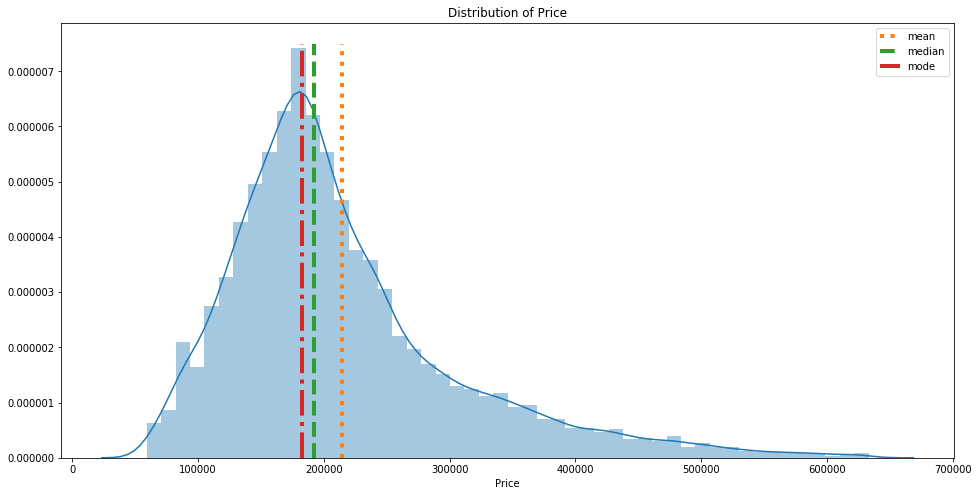

In [41]:
plt.figure(figsize = (16, 8))

sns.distplot(target)

target = np.linspace(0, 0.0000075, 100)
plt.plot([target_mean] * 100, target, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, target, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, target, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

#### Оценка распредения целевой переменной в разрезе других признаков

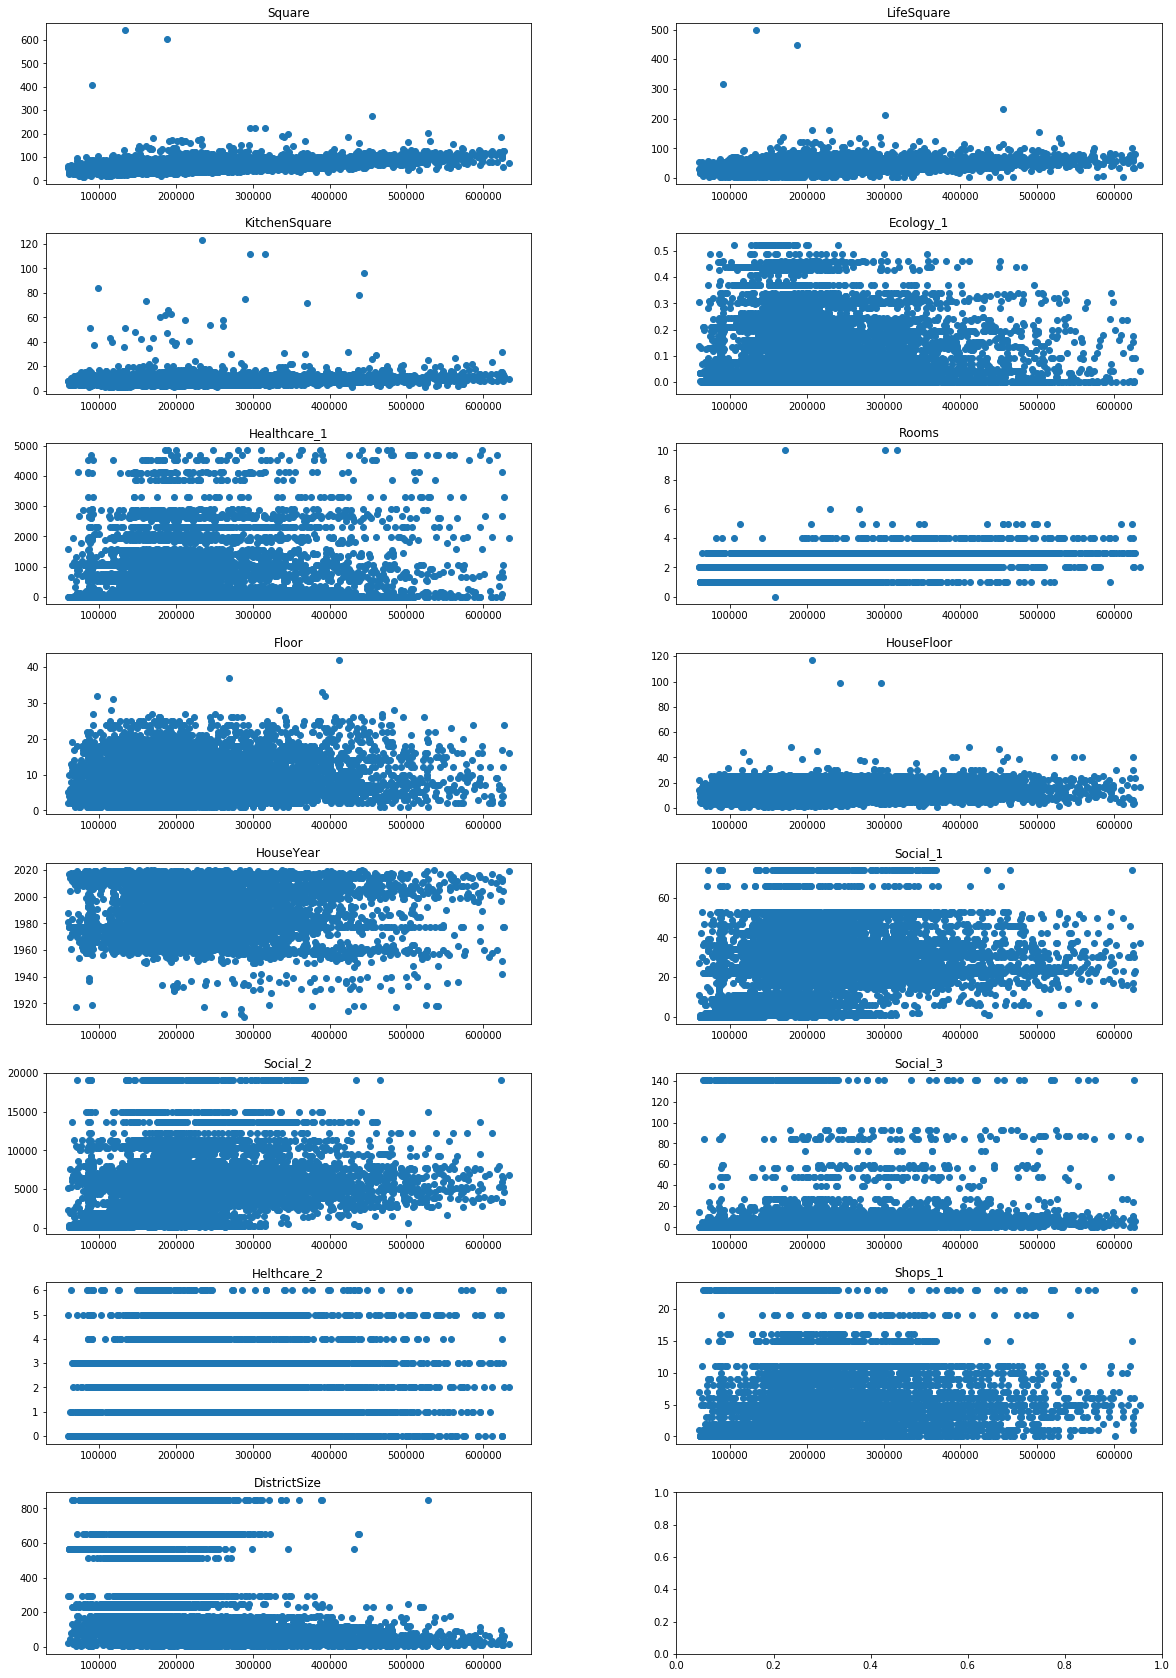

In [42]:
num_types = ['float64', 'float32', 'int64', 'int32']

target = df['Price']

df_num_features = df.select_dtypes(include = num_types)
df_num_features.drop("Price", axis=1, inplace=True)
df_num_features_columns = list(df_num_features.columns)

fig, ax = plt.subplots(nrows=8, ncols=2)
ax_list = ax.flatten()

fig.set_size_inches(20, 30)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, feature in enumerate(df_num_features_columns):
    ax_list[i].scatter(target, df[feature].values)
    ax_list[i].set_title(feature)


### Анализ признаков

#### Количественные признаки

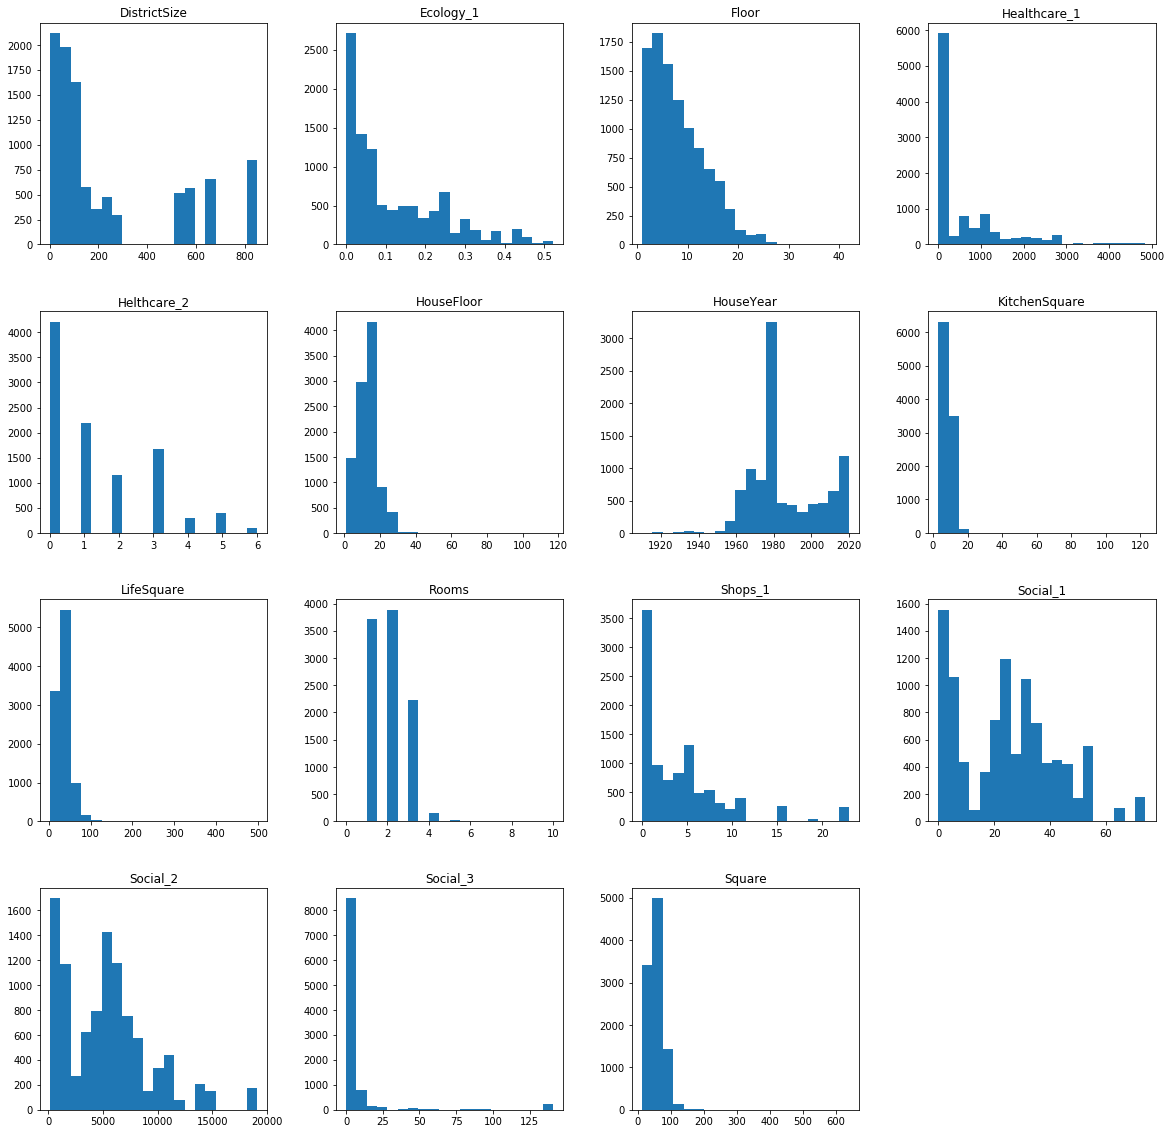

In [43]:
df_num_features.hist(figsize = (20, 20), bins = 20, grid = False);

#### Бинарные признаки

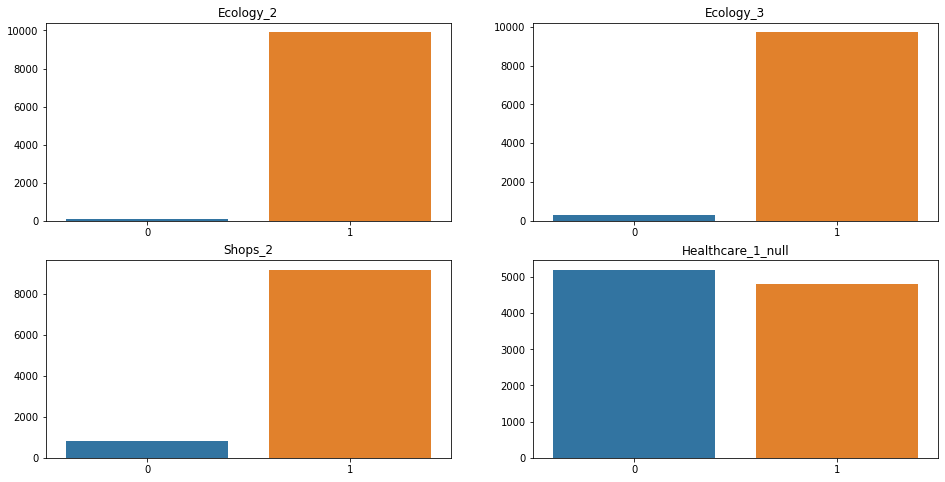

In [44]:
df_bin_features = df.select_dtypes(include='uint8')
    
plt.figure(figsize = (16, 8))

for i, colname in enumerate(df_bin_features.columns):
    counts = df_bin_features[colname].value_counts()
    
    plt.subplot(2, 2, i+1)
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

## Построение модели

In [45]:
def compare_predicted(train_true_values, train_pred_values, valid_true_values, valid_pred_values):
    
    plt.figure(figsize=(18,10))
    
    def r2_print(msg, true, pred):
        print(msg + str(round(r2(true, pred), 3)))
        
    def r2_plot(title, true, pred, i):
        plt.subplot(1, 2, i)
        sns.scatterplot(x=pred, y=true)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title(title)

    r2_print("Train R2:\t", train_true_values, train_pred_values)
    r2_print("Valid R2:\t", valid_true_values, valid_pred_values)
    
    r2_plot('Train sample prediction', train_true_values, train_pred_values, 1)
    r2_plot('Test sample prediction', valid_true_values, valid_pred_values, 2)
    
    plt.show()

In [46]:
def cross_valid_r2(model, x, target):
    cv_score = cross_val_score(model, x, target, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=13))
    print('cross_val_r2 =', cv_score.mean())

### Разбиение на train и valid

In [47]:
y = df['Price']
X = df.copy().drop('Price', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 13)

X_train.head()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Rooms,Floor,HouseFloor,HouseYear,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Healthcare_1_null,DistrictSize
4847,31.96072,19.48487,5.00000,0.12219,1308.00000,1,7,7,1963,1,1,25,4724,2,1,3,1,0,104
9992,78.24963,49.38510,10.00000,0.30032,0.00000,3,5,16,1976,1,1,52,10311,6,1,9,1,1,10
4621,33.93875,21.77293,9.00000,0.23221,80.00000,1,1,12,1968,1,1,24,4860,1,0,3,1,0,104
5774,43.12494,29.55689,5.00000,0.13633,262.00000,2,2,5,1962,1,1,30,6141,10,3,6,1,0,41
9294,75.72597,47.27686,9.51046,0.19578,0.00000,1,3,3,1977,1,1,23,5212,6,3,2,1,1,116


### Модель

In [48]:
rf_model = RandomForestRegressor(random_state = 13)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

Train R2:	0.962
Valid R2:	0.719


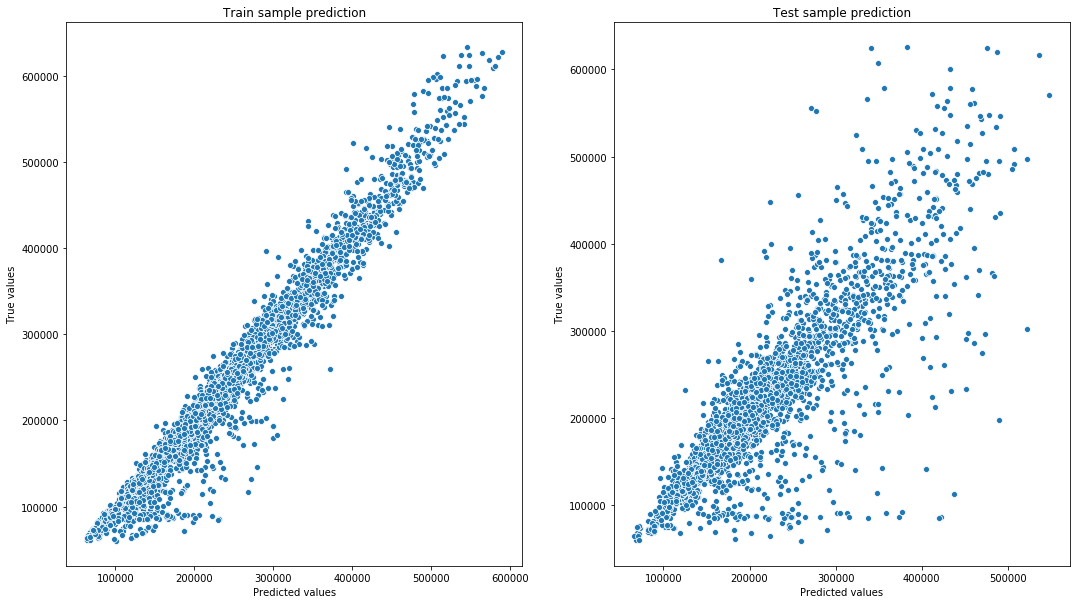

In [49]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

compare_predicted(y_train, y_train_preds, y_valid, y_test_preds)

In [50]:
cross_valid_r2(rf_model, X, y)

cross_val_r2 = 0.7359402055043452


**Важность признаков**

In [51]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, rf_model.feature_importances_), 
    columns=['feature_name', 'importance']
)

feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
feature_importances_sorted

,feature_name,importance
0,Square,0.43484
18,DistrictSize,0.22540
13,Social_3,0.04651
8,HouseYear,0.03607
1,LifeSquare,0.03531
3,Ecology_1,0.03120
7,HouseFloor,0.02979
12,Social_2,0.02915
5,Rooms,0.02585
11,Social_1,0.02477


## Кластеризация

### Масштабирование данных

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Square             10000 non-null  float64
 1   LifeSquare         10000 non-null  float64
 2   KitchenSquare      10000 non-null  float64
 3   Ecology_1          10000 non-null  float32
 4   Healthcare_1       10000 non-null  float32
 5   Price              10000 non-null  float32
 6   Rooms              10000 non-null  int32  
 7   Floor              10000 non-null  int32  
 8   HouseFloor         10000 non-null  int32  
 9   HouseYear          10000 non-null  int32  
 10  Ecology_2          10000 non-null  uint8  
 11  Ecology_3          10000 non-null  uint8  
 12  Social_1           10000 non-null  int32  
 13  Social_2           10000 non-null  int32  
 14  Social_3           10000 non-null  int32  
 15  Helthcare_2        10000 non-null  int32  
 16  Shops_1            1000

In [53]:
def scale_data(dFrame):
    df_num = dFrame.select_dtypes(['float64', 'float32', 'int64', 'int32'])
    df_cat = dFrame.select_dtypes(['uint8'])

    scaler = StandardScaler()

    df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
    df_scaled = pd.concat([df_scaled, df_cat], axis=1)
    
    return df_scaled

In [54]:
df_scaled = scale_data(df.copy().drop('Price', axis=1))
df_scaled.head()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Rooms,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,DistrictSize,Ecology_2,Ecology_3,Shops_2,Healthcare_1_null
0,-0.41562,-0.39223,-0.57346,-0.25053,-0.63787,0.13175,-0.29131,-0.76179,-0.86174,0.47417,0.65488,-0.12753,-0.88348,1.40836,-0.81905,1,1,1,1
1,0.41283,0.23233,-0.07533,-0.99805,-0.38038,1.34268,-0.29131,-0.76179,-0.37285,1.21568,1.23717,-0.29538,-0.21392,2.44870,-0.57739,1,1,1,0
2,-0.55759,-0.40667,-0.15891,-0.58159,-0.39218,0.13175,-0.10050,-0.26145,-0.91606,0.53121,0.60072,-0.33735,-0.21392,-0.25620,-0.25395,1,1,1,0
3,0.22788,0.97908,0.17373,2.68047,0.52514,0.13175,-0.10050,0.57246,-0.42717,-0.09623,0.09555,-0.21146,-0.88348,0.15994,-0.23536,1,1,1,0
4,-0.80558,-0.72590,-0.32439,-0.89497,1.59158,-1.07918,0.47192,-0.26145,-0.48149,0.58825,0.10579,-0.29538,0.45563,-0.04813,-0.54022,1,1,1,0


### Оценка оптимального количества кластеров методом "Локтя"

In [55]:
"""
Функция для оценки оптимального кол-ва кластеров методом локтя
"""
def apply_elbow_method(X):
    distortions = []
    K = range(2,18)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=13).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(16, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

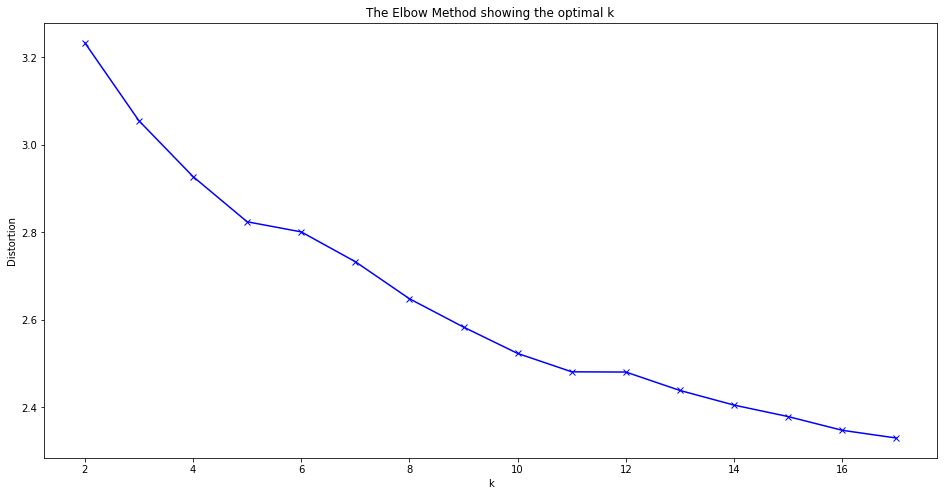

In [56]:
apply_elbow_method(df_scaled)

### Смешанные Гаусовы модели

In [57]:
def get_gmm(dFrame):
    labels_gmm = {}
    dummies_gmm = {}
    
    for i in [11]:    
        gmm = GaussianMixture(n_components=i, random_state = 13)
        labels_gmm[i] = gmm.fit_predict(dFrame)
        labels_gmm[i] = pd.Series(labels_gmm[i], name='gmm_'+str(i))
        dummies_gmm[i] = pd.get_dummies(labels_gmm[i], drop_first=True, prefix='gmm_'+str(i))
    
    return pd.concat(
        [dFrame, pd.concat(dummies_gmm.values(), axis=1)], 
        axis=1
    )

In [58]:
df_gmm = get_gmm(df_scaled)

df_gmm.head()

,Square,LifeSquare,KitchenSquare,Ecology_1,Healthcare_1,Rooms,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,DistrictSize,Ecology_2,Ecology_3,Shops_2,Healthcare_1_null,gmm_11_1,gmm_11_2,gmm_11_3,gmm_11_4,gmm_11_5,gmm_11_6,gmm_11_7,gmm_11_8,gmm_11_9,gmm_11_10
0,-0.41562,-0.39223,-0.57346,-0.25053,-0.63787,0.13175,-0.29131,-0.76179,-0.86174,0.47417,0.65488,-0.12753,-0.88348,1.40836,-0.81905,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,0.41283,0.23233,-0.07533,-0.99805,-0.38038,1.34268,-0.29131,-0.76179,-0.37285,1.21568,1.23717,-0.29538,-0.21392,2.44870,-0.57739,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,-0.55759,-0.40667,-0.15891,-0.58159,-0.39218,0.13175,-0.10050,-0.26145,-0.91606,0.53121,0.60072,-0.33735,-0.21392,-0.25620,-0.25395,1,1,1,0,0,0,0,0,0,0,0,1,0,0
3,0.22788,0.97908,0.17373,2.68047,0.52514,0.13175,-0.10050,0.57246,-0.42717,-0.09623,0.09555,-0.21146,-0.88348,0.15994,-0.23536,1,1,1,0,0,0,0,0,0,0,0,0,0,1
4,-0.80558,-0.72590,-0.32439,-0.89497,1.59158,-1.07918,0.47192,-0.26145,-0.48149,0.58825,0.10579,-0.29538,0.45563,-0.04813,-0.54022,1,1,1,0,0,0,0,0,0,0,0,1,0,0


#### Переобучение с новыми признаками

In [59]:
X_gmm = df_gmm
y_gmm = df['Price']

X_train_gmm, X_vaild_gmm, y_train_gmm, y_valid_gmm = train_test_split(X_gmm, y_gmm, test_size=0.3, shuffle=True, random_state=13)

Train R2:	0.962
Valid R2:	0.722


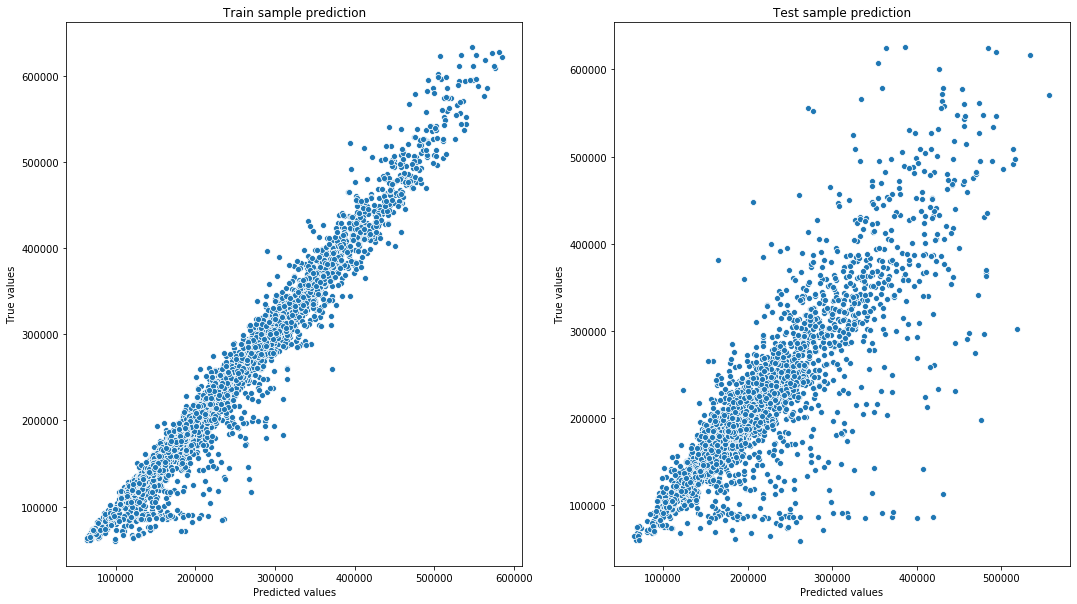

In [60]:
rf_model.fit(X_train_gmm, y_train_gmm)

y_train_preds_gmm = rf_model.predict(X_train_gmm)
y_valid_preds_gmm = rf_model.predict(X_vaild_gmm)

compare_predicted(y_train_gmm, y_train_preds_gmm, y_valid_gmm, y_valid_preds_gmm)

In [61]:
cross_valid_r2(rf_model, X_gmm, y_gmm)

cross_val_r2 = 0.7367861979039625


## Предсказание целевого признака на тестовых данных

Применим итоговую модель RandomForestRegressor + GaussianMixture на тестовых данных.

Для этого аналогичным образом проведем шкалирование и добавим новые признаки

In [62]:
df_test_scaled = scale_data(df_test)

df_gmm_test = get_gmm(df_test_scaled)

y_final = rf_model.predict(df_gmm_test)

final['Price'] = y_final
final.to_csv('AVKucherova_predictions.csv', index=False)

final.head()

,Id,Price
0,725,158748.49125
1,15856,244116.46109
2,5480,253766.69570
3,15664,306305.10859
4,14275,124613.82945
